# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [1]:
# Step 1: Load the netflix.pcap file
!pip install scapy

from scapy.all import rdpcap
from pathlib import Path

# Path to your pcap file (make sure it's in the same folder as this notebook)
pcap_path = Path("netflix.pcap")

# Check if file exists
assert pcap_path.exists(), "netflix.pcap not found! Place it in the same folder as this notebook."

# Load the pcap
packets = rdpcap(str(pcap_path))

# Basic info
print(f"Loaded {len(packets)} packets from {pcap_path.name}")
print("First packet summary:")
print(packets[0].summary())


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


Loaded 141471 packets from netflix.pcap
First packet summary:
Ether / IP / UDP / DNS Qry "b'fonts.gstatic.com.'" 


### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [2]:
# Step 2 (final working version): Identify Netflix traffic from DNS queries + responses
from scapy.all import DNS, DNSQR, DNSRR
import re

NETFLIX_PATTERNS = [
    r"(^|\.)netflix\.com$",
    r"(^|\.)nflxvideo\.net$",
    r"(^|\.)nflxso\.net$",
    r"(^|\.)nflxext\.com$",
    r"(^|\.)nflximg\.net$",
]
netflix_re = re.compile("|".join(NETFLIX_PATTERNS), re.IGNORECASE)

netflix_ips = set()
netflix_names = set()

for p in packets:
    if not p.haslayer(DNS):
        continue
    dns = p[DNS]
    # --- DNS Queries ---
    if dns.qr == 0 and len(dns.qd) > 0:
        try:
            qname = dns.qd[0].qname.decode(errors="ignore").rstrip(".").lower()
            if netflix_re.search(qname):
                netflix_names.add(qname)
        except Exception:
            continue
    # --- DNS Responses ---
    elif dns.qr == 1 and dns.ancount > 0:
        for i in range(dns.ancount):
            try:
                ans = dns.an[i]
                if isinstance(ans, DNSRR):
                    name = ans.rrname.decode(errors="ignore").rstrip(".").lower()
                    if netflix_re.search(name) and ans.type in (1, 28):  # A/AAAA
                        netflix_names.add(name)
                        netflix_ips.add(ans.rdata)
            except Exception:
                continue

print(f"Found {len(netflix_names)} Netflix domains and {len(netflix_ips)} IPs")
print("Example domains:", list(netflix_names)[:5])

# Filter packets to those IPs
netflix_packets = [
    p for p in packets
    if (p.haslayer('IP') and (p['IP'].src in netflix_ips or p['IP'].dst in netflix_ips))
]

print(f"Total Netflix packets: {len(netflix_packets)}")
for pkt in netflix_packets[:5]:
    print(pkt.summary())


Found 17 Netflix domains and 15 IPs
Example domains: ['codex.nflxext.com', 'push.prod.eu-west-1.prodaa.netflix.com', 'ipv4-c071-cdg001-ix.1.oca.nflxvideo.net', 'customerevents.eu-west-1.prodaa.netflix.com', 'occ-0-56-55.1.nflxso.net']
Total Netflix packets: 138633
Ether / IP / TCP 192.168.43.72:58451 > 198.38.120.130:https S
Ether / IP / TCP 192.168.43.72:58452 > 198.38.120.130:https S
Ether / IP / TCP 192.168.43.72:58453 > 198.38.120.130:https S
Ether / IP / TCP 192.168.43.72:58454 > 52.19.39.146:https S
Ether / IP / TCP 192.168.43.72:58455 > 52.19.39.146:https S


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [3]:
# Step 3 — Generate statistics and features manually for Netflix traffic
from scapy.all import IP, TCP, UDP
import pandas as pd
import numpy as np

# --- Group packets into flows (5-tuple: src, dst, sport, dport, proto)
flows = {}

for pkt in netflix_packets:
    if not pkt.haslayer(IP):
        continue
    ip = pkt[IP]
    proto = (
        "TCP" if pkt.haslayer(TCP)
        else "UDP" if pkt.haslayer(UDP)
        else "OTHER"
    )
    sport = pkt[TCP].sport if pkt.haslayer(TCP) else pkt[UDP].sport if pkt.haslayer(UDP) else 0
    dport = pkt[TCP].dport if pkt.haslayer(TCP) else pkt[UDP].dport if pkt.haslayer(UDP) else 0
    key = (ip.src, ip.dst, sport, dport, proto)
    t = float(pkt.time)
    size = len(pkt)

    if key not in flows:
        flows[key] = {"times": [], "sizes": []}
    flows[key]["times"].append(t)
    flows[key]["sizes"].append(size)

# --- Compute per-flow features
records = []
for (src, dst, sport, dport, proto), data in flows.items():
    times = np.array(data["times"])
    sizes = np.array(data["sizes"])
    if len(times) < 2:
        continue  # ignore 1-packet flows
    times.sort()
    iats = np.diff(times)  # inter-arrival times
    duration = times[-1] - times[0]
    total_bytes = sizes.sum()
    pkt_count = len(sizes)
    avg_pkt = sizes.mean()
    throughput = total_bytes / duration if duration > 0 else 0

    records.append({
        "src": src,
        "dst": dst,
        "sport": sport,
        "dport": dport,
        "proto": proto,
        "packets": pkt_count,
        "bytes": total_bytes,
        "avg_pkt_size": avg_pkt,
        "duration": duration,
        "throughput_Bps": throughput,
        "iat_mean": iats.mean(),
        "iat_std": iats.std(),
        "iat_min": iats.min(),
        "iat_max": iats.max(),
    })

# --- Build a DataFrame of features
df_features = pd.DataFrame(records)
print(f"Generated features for {len(df_features)} flows")
df_features.head()

Generated features for 110 flows


,src,dst,sport,dport,proto,packets,bytes,avg_pkt_size,duration,throughput_Bps,iat_mean,iat_std,iat_min,iat_max
0,192.168.43.72,198.38.120.130,58451,443,TCP,12,1064,88.666667,14.440177,73.683308,1.312743,2.243136,0.000158,7.958562
1,192.168.43.72,198.38.120.130,58452,443,TCP,11,998,90.727273,14.442865,69.099863,1.444287,2.735499,0.000191,9.313323
2,192.168.43.72,198.38.120.130,58453,443,TCP,12,1064,88.666667,14.437420,73.697377,1.312493,2.248272,0.000234,7.973116
3,192.168.43.72,52.19.39.146,58454,443,TCP,208,25627,123.206731,138.854511,184.560082,0.670795,4.253360,0.000000,49.886644
4,192.168.43.72,52.19.39.146,58455,443,TCP,27,3382,125.259259,74.817607,45.203263,2.877600,9.098719,0.000000,46.446035


**Write a brief justification for the features that you have chosen.**

The chosen features capture the essential characteristics of Netflix video streaming flows that influence perceived video quality.
- Packets, Bytes, and Duration: measure the total traffic volume and flow length, reflecting how much data is transmitted during playback.
- Average Packet Size: distinguishes between small control packets and large video data packets.
- Throughput (Bytes per Second): represents the effective data rate of the flow and correlates directly with video bitrate and resolution.
- Inter-Arrival Time (IAT) Mean, Standard Deviation, Minimum, and Maximum: describe the timing between packets. Stable, low-variance IATs indicate smooth streaming, while high variance may reflect buffering or adaptive bitrate changes.

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [4]:
# Step 4 — Estimate segment download rate per flow

segment_gap = 1.0   # seconds between packets that define segment boundary
window_size = 10.0  # seconds for rate normalization

segment_rates = []

for (src, dst, sport, dport, proto), data in flows.items():
    times = np.sort(np.array(data["times"]))
    if len(times) < 2:
        segment_rates.append(0)
        continue

    # gaps between packets
    iats = np.diff(times)
    # segment boundaries where the gap > 1 second
    segment_count = np.sum(iats > segment_gap) + 1  # +1 for the first segment
    duration = times[-1] - times[0]
    rate = segment_count / (duration / window_size) if duration > 0 else 0
    segment_rates.append(rate)

# Add to your dataframe
df_features["segment_download_rate"] = segment_rates[:len(df_features)]
print("Added 'segment_download_rate' to feature set.")
df_features.head()


Added 'segment_download_rate' to feature set.


,src,dst,sport,dport,proto,packets,bytes,avg_pkt_size,duration,throughput_Bps,iat_mean,iat_std,iat_min,iat_max,segment_download_rate
0,192.168.43.72,198.38.120.130,58451,443,TCP,12,1064,88.666667,14.440177,73.683308,1.312743,2.243136,0.000158,7.958562,3.462561
1,192.168.43.72,198.38.120.130,58452,443,TCP,11,998,90.727273,14.442865,69.099863,1.444287,2.735499,0.000191,9.313323,2.769534
2,192.168.43.72,198.38.120.130,58453,443,TCP,12,1064,88.666667,14.437420,73.697377,1.312493,2.248272,0.000234,7.973116,3.463223
3,192.168.43.72,52.19.39.146,58454,443,TCP,208,25627,123.206731,138.854511,184.560082,0.670795,4.253360,0.000000,49.886644,1.656410
4,192.168.43.72,52.19.39.146,58455,443,TCP,27,3382,125.259259,74.817607,45.203263,2.877600,9.098719,0.000000,46.446035,1.069267


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [5]:
import pickle
import pandas as pd

# Load the Netflix dataset pickle file
with open("netflix_dataset.pkl", "rb") as f:
    netflix_dataset = pickle.load(f)

print("netflix_dataset.pkl loaded successfully!")
print("Type:", type(netflix_dataset))

# If the file contains a DataFrame, show its first few rows
if isinstance(netflix_dataset, pd.DataFrame):
    display(netflix_dataset.head())
else:
    print("Keys:", list(netflix_dataset.keys())[:10])


netflix_dataset.pkl loaded successfully!
Type: <class 'pandas.core.frame.DataFrame'>


/var/folders/ry/zs7zmfjs1x31l0ctnwz8m8mw0000gn/T/ipykernel_2385/880789431.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  netflix_dataset = pickle.load(f)


,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,...,userTwoRetransmit,userUrgFlags,userXRetransmit,userZeroRetransmit,service,startup3.3,startup6.6,startup5,startup10,startup_mc
208,"[[4380.0], [4380.0], [19682.095238095237], [23...",148947.1,43473.0,43473.0,185098.0,185098.0,361832.3,361832.3,461040.2,461040.2,...,0.0,0,0.108730,0.557937,netflix,False,False,False,False,12.0
209,"[[179260.0], [130204.0], [49666.09523809524], ...",91984.2,101882.0,101882.0,122323.0,122323.0,159843.4,159843.4,181011.8,181011.8,...,0.0,0,0.116865,0.549802,netflix,False,False,False,False,12.0
210,"[[317962.0], [83192.4], [170850.7619047619], [...",147725.0,111373.0,111373.0,224157.0,224157.0,286280.0,286280.0,325845.8,325845.8,...,0.0,0,0.126852,0.539815,netflix,False,False,False,False,12.0
211,"[[396800.0], [98961.6], [246910.09523809524], ...",246420.6,297522.0,297522.0,330737.5,330737.5,361030.7,361030.7,378404.0,378404.0,...,0.0,0,0.186111,0.480556,netflix,False,False,False,False,12.0
212,"[[325264.0], [331102.4], [365584.38095238095],...",336681.0,354461.0,354461.0,399719.5,399719.5,409866.3,409866.3,414060.0,414060.0,...,0.0,0,0.194444,0.472222,netflix,False,False,False,False,12.0


### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [6]:
import pandas as pd

# Define valid resolutions
valid_resolutions = [240, 360, 480, 720, 1080]

# Check which column holds resolution info (commonly named 'resolution' or similar)
print("Available columns:", list(netflix_dataset.columns))

# Filter rows to keep only valid resolutions
if 'resolution' in netflix_dataset.columns:
    before = len(netflix_dataset)
    netflix_dataset = netflix_dataset[netflix_dataset['resolution'].isin(valid_resolutions)]
    after = len(netflix_dataset)
    print(f"Cleaned dataset: kept {after}/{before} rows with valid resolutions.")
else:
    print("Couldn't find a 'resolution' column — please verify the column name.")
    print("Here’s a sample of column names for reference:")
    display(netflix_dataset.head())


Available columns: ['10_EWMA_chunksizes', '10_avg_chunksize', '10_chunksizes_50', '10_chunksizes_50R', '10_chunksizes_75', '10_chunksizes_75R', '10_chunksizes_85', '10_chunksizes_85R', '10_chunksizes_90', '10_chunksizes_90R', '10_max_chunksize', '10_min_chunksize', '10_std_chunksize', 'absolute_timestamp', 'access_50_perc', 'access_75_perc', 'access_avg', 'access_max', 'access_min', 'access_stddev', 'access_var', 'ads', 'all_prev_down_chunk_iat_50', 'all_prev_down_chunk_iat_50R', 'all_prev_down_chunk_iat_75', 'all_prev_down_chunk_iat_75R', 'all_prev_down_chunk_iat_85', 'all_prev_down_chunk_iat_85R', 'all_prev_down_chunk_iat_90', 'all_prev_down_chunk_iat_90R', 'all_prev_down_chunk_iat_avg', 'all_prev_down_chunk_iat_max', 'all_prev_down_chunk_iat_min', 'all_prev_down_chunk_iat_std', 'all_prev_up_chunk_iat_50', 'all_prev_up_chunk_iat_50R', 'all_prev_up_chunk_iat_75', 'all_prev_up_chunk_iat_75R', 'all_prev_up_chunk_iat_85', 'all_prev_up_chunk_iat_85R', 'all_prev_up_chunk_iat_90', 'all_prev

2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [7]:
# Step — Drop unhelpful / identifier columns
cols_to_drop = [
    'session_id',
    'home_id',
    'video_id',
    'absolute_timestamp',
    'relative_timestamp',
    'deployment_session_id',
    'index'
]

# Only drop those that actually exist in the dataframe
cols_to_drop = [c for c in cols_to_drop if c in netflix_dataset.columns]
netflix_dataset = netflix_dataset.drop(columns=cols_to_drop)

print("Dropped unnecessary columns.")
print("Remaining columns:", len(netflix_dataset.columns))


Dropped unnecessary columns.
Remaining columns: 244


**Briefly explain why you removed those columns.**

The removed columns such as session IDs, timestamps, and video identifiers do not provide meaningful information for predicting video quality. They are metadata that uniquely identify a session or record (session_id, deployment_session_id, video_id, etc.) or describe when the data was collected (absolute_timestamp, chunk_start_time, etc.), rather than how the network behaved. Keeping these columns could cause the model to overfit, learning patterns tied to specific sessions or times instead of general network characteristics. By removing them, we ensure that the model relies only on relevant behavioral and performance features (e.g., throughput, bitrate, inter-arrival times) that actually influence video quality.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [8]:
# Step — Prepare Your Data
# ------------------------

import pandas as pd
from sklearn.model_selection import train_test_split

# Define the target (label) column
# We'll predict the video resolution since it represents quality.
target_col = 'resolution'

# Separate features (X) and labels (y)
#    Drop only the label column to get the feature matrix.
X = netflix_dataset.drop(columns=[target_col])
y = netflix_dataset[target_col]

print("Feature matrix shape:", X.shape)
print("Label vector shape:", y.shape)
print("\nTarget variable distribution:")
print(y.value_counts())

# Perform a train-test split
#    80% training data, 20% testing data, stratified to preserve resolution balance.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTrain/test split complete.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples:  {X_test.shape[0]}")

# Optional sanity check
print("\nTraining label distribution:")
print(y_train.value_counts(normalize=True).round(3))
print("\nTesting label distribution:")
print(y_test.value_counts(normalize=True).round(3))


Feature matrix shape: (49748, 243)
Label vector shape: (49748,)

Target variable distribution:
resolution
480.0     29486
720.0      9457
1080.0     4628
360.0      4476
240.0      1701
Name: count, dtype: int64

Train/test split complete.
Training samples: 39798
Testing samples:  9950

Training label distribution:
resolution
480.0     0.593
720.0     0.190
1080.0    0.093
360.0     0.090
240.0     0.034
Name: proportion, dtype: float64

Testing label distribution:
resolution
480.0     0.593
720.0     0.190
1080.0    0.093
360.0     0.090
240.0     0.034
Name: proportion, dtype: float64


### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Numeric features used: 234
Model training complete!
Accuracy: 0.9511
Weighted F1 Score: 0.9496

Classification Report:
              precision    recall  f1-score   support

       240.0       0.80      0.61      0.69       340
       360.0       0.92      0.85      0.88       895
       480.0       0.96      0.98      0.97      5897
       720.0       0.96      0.94      0.95      1892
      1080.0       0.97      0.99      0.98       926

    accuracy                           0.95      9950
   macro avg       0.92      0.87      0.90      9950
weighted avg       0.95      0.95      0.95      9950



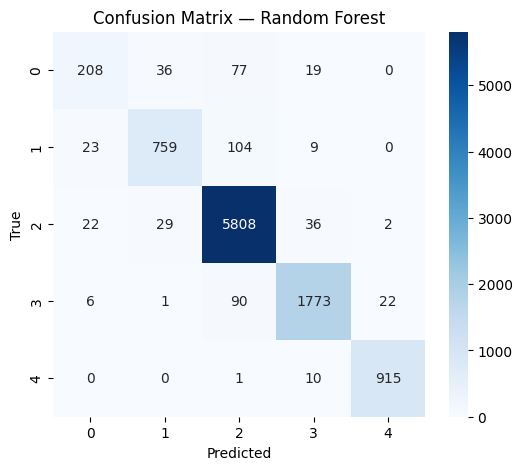

In [9]:
# Step — Train and Tune Your Model (Fixed for Numeric Data)
# ----------------------------------------------------------
!pip install seaborn --quiet
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns for modeling
X_train_num = X_train.select_dtypes(include=[np.number])
X_test_num  = X_test.select_dtypes(include=[np.number])

print("Numeric features used:", X_train_num.shape[1])

# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train_num, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_num)

# Evaluate model performance
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Model training complete!")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import numpy as np

# Use numeric data again
X_train_num = X_train.select_dtypes(include=[np.number])
X_test_num  = X_test.select_dtypes(include=[np.number])

# Define parameter distributions (not a full grid)
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
}

# Base model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized search with fewer combinations
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=15,            # test 15 random combos instead of 108
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='f1_weighted'
)

# Run the search
random_search.fit(X_train_num, y_train)

print("\nRandomized search complete!")
print("Best Parameters:", random_search.best_params_)
print(f"Best Weighted F1 Score (CV): {random_search.best_score_:.4f}")

# Evaluate on test data
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_test_num)

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print("\nTuned Model Performance on Test Set:")
print(f"Accuracy: {acc_best:.4f}")
print(f"Weighted F1 Score: {f1_best:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix — Tuned Random Forest (RandomizedSearchCV)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Fitting 3 folds for each of 15 candidates, totalling 45 fits


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

In [ ]:
# Step — Part 3: Predict the Ongoing Resolution of a Netflix Session
# -----------------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np

# Select numeric features from X_test (same as model input)
X_test_num = X_test.select_dtypes(include=[np.number])

# Predict resolutions using the trained Random Forest model
y_pred_test = best_rf.predict(X_test_num)

print("Predictions complete!")
print("First 10 predicted resolutions:", y_pred_test[:10])

# Simulate time progression
# Assume each sample corresponds to a 10-second interval
time_intervals = np.arange(len(y_pred_test)) * 10  # seconds

# Plot predicted vs actual resolutions
plt.figure(figsize=(12,6))
plt.plot(time_intervals, y_pred_test, label="Predicted Resolution", color="blue", linewidth=1.5)
plt.plot(time_intervals, y_test.values, label="Actual Resolution", color="red", alpha=0.6)
plt.title("Predicted vs Actual Video Resolution Over Time (10-Second Intervals)")
plt.xlabel("Time (seconds)")
plt.ylabel("Resolution (p)")
plt.legend()
plt.grid(True)
plt.show()
